man lernt
* screenscraping in der wikipedia (vertrautheit mit HTML hilfreich, aber keine voraussetzung)
* erzeugung von tabularen daten aus wenig strukturierten inhalten der Wikipedia
* was ist eine prozedur/methode
* netzwerkanalyse
* export data to visualize it in a "normal" website using the D3.js library

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import networkx as nx # network analysis
import itertools
from datetime import datetime # for time measurement
import sys
import os
import unicodedata as ucd

#erklären, warum man das braucht
def printLog(text):
    now=str(datetime.now())
    print "["+now+"]\t"+text
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## config paths etc

In [2]:
isMarvel=True
if isMarvel:
    # Marvel
    imageDownloadPath="./img.marvel_chars/"
    csvFilePath="marvel_superheroes.csv"
    pathPrefix="marvel"
else:
    # DC Comics
    imageDownloadPath="./img.dc_chars/"
    csvFilePath="dc_superheroes.csv"
    pathPrefix="dc"

In [4]:
!pip install wikipedia

You are using pip version 7.1.2, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You will find the documentation of the Wikipedia package [_here_](https://pypi.python.org/pypi/wikipedia).

In [5]:
import wikipedia as wiki

In [6]:
#page = wiki.page("batman")
#page = wiki.page("catwoman")

Anaconda comes with _Beautiful Soup_, a library for screen-scraping [documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [7]:
#from bs4 import BeautifulSoup

# Beautiful Soup needs the HTML of the Wikipedia page
#html_doc=page.html()
#soup = BeautifulSoup(html_doc, 'html.parser')
#print(soup.prettify())

In [8]:
#tables=soup.find_all('table',class_="infobox")
#infoboxTable=tables[0] # fill fail if no infobox is presented, will be fixed later
#print infoboxTable.prettify()

we expect the following _th_ elements as seperators
* <th scope="row" style="width: 40%;">Alter ego</th>
* <th scope="row" style="width: 40%;">Team affiliations</th>
* <th scope="row" style="width: 40%;">Partnerships</th>
* <th scope="row" style="width: 40%;">Notable aliases</th>
* <th scope="row" style="width: 40%;">Abilities</th>

In [9]:
#rows=infoboxTable.find_all("tr")
#for row in rows:
#    if row.th is not None:
#        print row.th.string

In [10]:
#abilityRow=None
#partnerRow=None
#firstAppearance=""
#p = re.compile('\d\d\d\d') # we expect the year to have four digits

#for row in rows:
#    if row.th is not None and row.th.string == "First appearance":
#        rawText=row.td.get_text()
#        m = p.search(rawText)
#        firstAppearance=m.group()
#    elif row.th is not None and row.th.string == "Abilities":
#        abilityRow=row
#    elif row.th is not None and row.th.string == "Partnerships":
#        partnerRow=row

In [11]:
# as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
#abilities=[]
#if abilityRow is not None:
#    li=abilityRow.find_all("li")
#    for l in li:
        # check if an anchor (a link to a website) is contained
#        if l.a is not None:
            # if so, discard the link and keep the plain text
#            l.a.unwrap()
#        abilities.append(l.get_text().strip())
        

In [12]:
#partnerships=[]
#if partnerRow is not None:
#    partners=partnerRow.find_all("a")
#    for p in partners:
#        partnerships.append(p.string)

In [13]:
#for a in abilities:
#    print a

In [14]:
#for p in partnerships:
#    print p

In [15]:
#print firstAppearance

now, we will define a procedure/sub-routine for later usage


More on [_regular expressions_](https://docs.python.org/2/howto/regex.html)

In [16]:
def extractData(myDoc):
    soup = BeautifulSoup(myDoc, 'html.parser')
    #print soup.title
    tables=soup.find_all('table',class_="infobox")
    # if there is no infobox, ignore the page
    if len(tables)>=1:
        infoboxTable=tables[0]
        # try to get the name of the character
        if infoboxTable.tr.th is not None:
            name=infoboxTable.tr.th.get_text()
        else:
            #if it is not part of the infobox take it from the HTML page's title and strip the Wikipedia reference
            name=soup.title.get_text().replace(" - Wikipedia, the free encyclopedia","")
        abilityRow=None
        partnerRow=None
        firstAppearance="2020" # dummy entry in case the "first appearance" entry is missing
        abilities=[]
        partnerships=[]
        
        # image processing
        if infoboxTable.find('img'):
            articleImage=infoboxTable.find('img')["src"]
        else:
            articleImage=None

        p = re.compile('\d\d\d\d') # we expect the year of first appearance to have four digits
        
        rows=infoboxTable.find_all("tr")
        for row in rows:
            if row.th is not None and row.th.string == "First appearance":
                rawText=row.td.get_text()
                m = p.search(rawText)
                # deal with missing years of first appearance
                if m:
                    firstAppearance=m.group()
            elif row.th is not None and row.th.string == "Abilities":
                abilityRow=row
            elif row.th is not None and row.th.string == "Partnerships":
                partnerRow=row

        # as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
        if abilityRow is not None:
            li=abilityRow.find_all("li")
            for l in li:
                # check if an anchor (a link to a website) is contained
                if l.a is not None:
                    # if so, discard the link and keep the plain text
                    l.a.unwrap()
                abilities.append(l.get_text().strip())
        # a fix for abilities without the ul/li structure
            if len(li)==0:
                rawStr=str(abilityRow.td)
                rawStr=rawStr.replace("<td>","").replace("</td>","").replace("\n","").strip()
                # abilities are sometimes separated by  <br/>, a comma, a period, or "and"
                rawStr=rawStr.replace("<br/>",";")
                rawStr=rawStr.replace(",",";")
                rawStr=rawStr.replace(".",";")
                # we have to treat 'and' in a special way as it may be contained as a substring in "normal" words
                #rawStr=rawStr.replace("and",";")
                rawTokens=rawStr.split(" and ")
                rawStr=";".join(rawTokens)
                # remove all other HTML tags
                p2 = re.compile(r'<.*?>')
                rawStr=p2.sub(' ', rawStr)
                # clean whitespaces surrounding the string
                rawStr.strip()
                rawTokens=rawStr.split(";")
                for t in rawTokens:
                    t=t.strip()
                    # we have to ignore additional noise such as the following "abilities"
                    if t.lower()=="see below":
                        pass
                    elif t.lower()=="various":
                        pass
                    elif t.lower()=="varies":
                        pass
                    elif t.lower()=="none":
                        pass
                    else:
                        if str(t):
                            abilities.append(str(t))

        if partnerRow is not None:
            partners=partnerRow.find_all("a")
            for p in partners:
                if p.string is not None: # some Marvel pages "suffer" from empty <a>
                    partnerships.append(p.string)

        
        
        result=dict()
        result["name"]=name
        result["firstAppearance"]=int(firstAppearance)
        result["abilities"]=abilities
        result["abilitiesCount"]=len(abilities)
        result["partnerships"]=partnerships
        result["partnershipsCount"]=len(partnerships)
        if articleImage:
            result["imageURL"]="https:"+str(articleImage)
        else:
            result["imageURL"]="https://None"
        #print abilities
        return result
    else:
        return None

### Debug

In [17]:
html_doc=urllib.urlopen("https://en.wikipedia.org/wiki/Juggernaut_(comics)")
r=extractData(html_doc)
print r

print "\n NEXT\n"

html_doc=urllib.urlopen("https://en.wikipedia.org/wiki/Batman")
r=extractData(html_doc)
print r

{'partnershipsCount': 2, 'abilities': ['Superhuman strength', 'Extreme durability', 'Force field generation', 'Virtually unstoppable momentum', 'Immunity to mental attacks via helmet'], 'name': u'Juggernaut', 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/4/44/Juggernaut2.PNG/250px-Juggernaut2.PNG', 'abilitiesCount': 5, 'firstAppearance': 1965, 'partnerships': [u'Black Tom Cassidy', u'Siryn']}

 NEXT

{'partnershipsCount': 8, 'abilities': [u'Genius-level intellect', u'Peak human physical and mental condition', u'Master martial artist and hand-to-hand combatant', u'Master detective', u'Utilizes high-tech equipment and weapons'], 'name': u'Batman', 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/7/75/Comic_Art_-_Batman_by_Jim_Lee_%282002%29.png/250px-Comic_Art_-_Batman_by_Jim_Lee_%282002%29.png', 'abilitiesCount': 5, 'firstAppearance': 1939, 'partnerships': [u'Robin', u'Batgirl', u'Nightwing', u'James "Jim" Gordon', u'Green Arrow (Oliver Queen)', u'Catwoman', u

methodenaufruf erklären

In [18]:
categoryPages=[]
if not isMarvel:
    # DC superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pageuntil=Dragon+King%0ADragon+King+%28DC+Comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Krypto#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Robin%0ARobin+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=XS+%28comics%29#mw-pages")
    # general DC characters
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pageuntil=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pagefrom=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
else:
    # Marvel superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pageuntil=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Jameson%0AJohn+Jameson+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Prime+%28Comics%29%0APrime+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Talon+%28Marvel+Comics%29#mw-pages")

```
<div id="mw-pages">
```
wird gesucht

In [19]:
def getSuperheroes(myCategories,myDictionary):
    for c in myCategories:
    # ignore <a class="mw-redirect"> as they redirect into articles, 
    # to be precise, we only consider <a> tags without a class atrribute 
    # because we are only interested in superheroes with distinct wikipedia articles
        items=c.ul.find_all("li")
        for item in items:
            if item.a.get("class") is None:
                myDictionary[item.a["title"]]=item.a["href"]


startTime=datetime.now()
printLog("Fetching superhero URLs...")

superheroes=OrderedDict() # we use an ordered dict here because we want to preserve the order items were added
for catPage in categoryPages:
    html_doc=urllib.urlopen(catPage)
    soup = BeautifulSoup(html_doc, 'html.parser')
    categories=soup.select("#mw-pages")[0].select(".mw-category-group")
    getSuperheroes(categories,superheroes) # we pass the superheroes dictionary on to merge the heroes extracted from all pages

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2016-02-12 18:37:19.882396]	Fetching superhero URLs...
[2016-02-12 18:37:24.477033]	Processing completed in 0:00:04.594450.


checken, da ursprünglich characters abgefragt wurden: __Relationship of Clark Kent and Lois Lane__ is obviously no superhero but we have to deal with it later

## Wrap Things Up

the processing will take a while, i.e., ca. 4-5 minutes on my notebook for DC comics

In [20]:
wikiBaseURL="https://en.wikipedia.org"
heroFeats=[]
i=0;
countItems=len(superheroes)

printLog("Processing "+str(countItems)+" Wikipedia pages. This will take a while...")

startTime=datetime.now()


for key, value in superheroes.iteritems():
    i=i+1
    wikiURL=wikiBaseURL+value
    #print "Processing "+wikiURL+" ; "+str(i)+" of "+str(countItems)
    html_doc=urllib.urlopen(wikiURL)
    r=extractData(html_doc)
    if r:
        r["url"]=wikiURL
        heroFeats.append(r)
    else:
        print "\t"+wikiURL+" does not contain an infobox. Processing aborted."

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2016-02-12 18:37:24.491607]	Processing 870 Wikipedia pages. This will take a while...
	https://en.wikipedia.org/wiki/Blue_Ear_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Citizen_V does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Human_Top_(Bruce_Bravelle) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Pixx does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Sequoia_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Spider-Man:_India does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/White_Tiger_(comics) does not contain an infobox. Processing aborted.
[2016-02-12 18:47:53.198326]	Processing completed in 0:10:28.705532.


the next download takes approx. 2-3 minutes

In [21]:
printLog("Downloading images. This will take a while...")

startTime=datetime.now()
# downloading images

if not os.path.exists(imageDownloadPath):
    os.makedirs(imageDownloadPath)

for i,hero in enumerate(heroFeats):
    hero["localFilePath"]="N/A" # caveat wg. JSON http://stackoverflow.com/questions/13715891/d3-json-uncaught-typeerror-cannot-read-property-children-of-undefined
    iURL=hero["imageURL"]
    if not iURL=="https://None":
        tokens=iURL.split(".")
        suffix=tokens[-1]
        localFilePath=imageDownloadPath+str(i)+"."+suffix
        hero["localFilePath"]=localFilePath
        try:
            urllib.urlretrieve(iURL,localFilePath)
        except IOError: # if we would catch all other exception, we would have a hard time to stop the kernel at all
            print "Downloading error while accessing: "+hero["imageURL"]
duration=datetime.now()-startTime
printLog("Downloading completed in "+str(duration)+".")

[2016-02-12 18:47:53.211730]	Downloading images. This will take a while...
[2016-02-12 18:53:51.123984]	Downloading completed in 0:05:57.909717.


as the processing took a while, it would be handy to save the result, in order to do so, we will create a pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) out of the data

In [22]:
rows=[]
columns=["Name","Year","Decade","Abilities","AbilitiesCount","Partnerships","PartnershipsCount","URL","ImageURL","localFilePath"]

for hero in heroFeats:
    rowx=[]
    rowx.append(hero["name"])
    firstAp=hero["firstAppearance"]
    rowx.append(firstAp)
    # calculate the decade
    if firstAp<2000:
        rowx.append(1900+int((hero["firstAppearance"]-1900)/10)*10)
    else:
        rowx.append(2000+int((hero["firstAppearance"]-2000)/10)*10)
    rowx.append(",".join(hero["abilities"]))
    rowx.append(hero["abilitiesCount"])
    rowx.append(",".join(hero["partnerships"]))
    rowx.append(hero["partnershipsCount"])
    rowx.append(hero["url"])
    rowx.append(hero["imageURL"])
    rowx.append(hero["localFilePath"])
    rows.append(rowx)

df=pd.DataFrame(rows,columns=columns)
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/0.png
1,Abyss,1997,1990,"Dimensional Form,Dimensional transportation,Sh...",4,,0,https://en.wikipedia.org/wiki/Abyss_(comics),https://None,N/A
2,Access,1996,1990,"Cross-dimensional awareness,Dimensional transp...",4,,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.marvel_chars/2.jpg
3,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./img.marvel_chars/3.jpg
4,Aegis,1999,1990,"Aegis breastplate grants:,energy blasts,energy...",4,,0,https://en.wikipedia.org/wiki/Aegis_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/4.jpg


apply-statement erklären, Unicode-safe machen (bzw. auf ASCII herunterbrechen)

In [23]:
# to avoid spelling issues, we capitalize all superheroes' names
# lambda Konzept erläutern
try:
    df['NameCaps'] = df.Name.apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['NameCaps'] = df.Name.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
#    utf8str=row[13].decode('utf-8')
#    str2=ucd.normalize('NFKD', utf8str).encode('ascii','ignore')
try:
    df['PartnershipsCaps'] = df.Partnerships.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['PartnershipsCaps'] = df.Partnerships.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
try:
    df['AbilitiesCaps'] = df.Abilities.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['AbilitiesCaps'] = df.Abilities.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
1,Abyss,1997,1990,"Dimensional Form,Dimensional transportation,Sh...",4,,0,https://en.wikipedia.org/wiki/Abyss_(comics),https://None,N/A,ABYSS,,"DIMENSIONAL FORM,DIMENSIONAL TRANSPORTATION,SH..."
2,Access,1996,1990,"Cross-dimensional awareness,Dimensional transp...",4,,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.marvel_chars/2.jpg,ACCESS,,"CROSS-DIMENSIONAL AWARENESS,DIMENSIONAL TRANSP..."
3,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./img.marvel_chars/3.jpg,ADEPT,,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
4,Aegis,1999,1990,"Aegis breastplate grants:,energy blasts,energy...",4,,0,https://en.wikipedia.org/wiki/Aegis_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/4.jpg,AEGIS,,"AEGIS BREASTPLATE GRANTS:,ENERGY BLASTS,ENERGY..."


to save it to disk, a CSV file is a possible solution; ? operator erklären

we have to pass the encoding parameter as our data frame contains Unicode data, "\t" as separator because of the commas we used to separate the abilities etc.

In [24]:
df.to_csv(csvFilePath,index=False,header=True,encoding='utf-8', sep="\t")

In [25]:
#df.to_csv?

# Continuing the Analysis
later, we could read the data again with [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)

In [3]:
df=pd.read_csv(csvFilePath,encoding='utf-8', sep="\t",dtype={"Partnerships":'str'})
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
1,Abyss,1997,1990,"Dimensional Form,Dimensional transportation,Sh...",4,NaN,0,https://en.wikipedia.org/wiki/Abyss_(comics),https://None,NaN,ABYSS,NaN,"DIMENSIONAL FORM,DIMENSIONAL TRANSPORTATION,SH..."
2,Access,1996,1990,"Cross-dimensional awareness,Dimensional transp...",4,NaN,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.marvel_chars/2.jpg,ACCESS,NaN,"CROSS-DIMENSIONAL AWARENESS,DIMENSIONAL TRANSP..."
3,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,NaN,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./img.marvel_chars/3.jpg,ADEPT,NaN,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
4,Aegis,1999,1990,"Aegis breastplate grants:,energy blasts,energy...",4,NaN,0,https://en.wikipedia.org/wiki/Aegis_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/4.jpg,AEGIS,NaN,"AEGIS BREASTPLATE GRANTS:,ENERGY BLASTS,ENERGY..."


In [4]:
countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print "Attention! Names are not unique."

Total number of names: 863, Unique number of names: 827
Attention! Names are not unique.


to drop the duplicates we apply a rather simple strategy, we keep the oldest superheroes
first, sort
second remove duplicates with pandas utility function [drop_duplicates()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.drop_duplicates.html)

subset, inplace erklären

In [5]:
df.drop_duplicates(subset='NameCaps',keep='first',inplace=True)

countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print "Attention! Names are not unique."

Total number of names: 827, Unique number of names: 827


In [6]:
# the "lonely" superheroes
df2=df[df["Partnerships"].isnull()]
#df2.shape
df2

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
1,Abyss,1997,1990,"Dimensional Form,Dimensional transportation,Sh...",4,NaN,0,https://en.wikipedia.org/wiki/Abyss_(comics),https://None,NaN,ABYSS,NaN,"DIMENSIONAL FORM,DIMENSIONAL TRANSPORTATION,SH..."
2,Access,1996,1990,"Cross-dimensional awareness,Dimensional transp...",4,NaN,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.marvel_chars/2.jpg,ACCESS,NaN,"CROSS-DIMENSIONAL AWARENESS,DIMENSIONAL TRANSP..."
3,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,NaN,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./img.marvel_chars/3.jpg,ADEPT,NaN,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
4,Aegis,1999,1990,"Aegis breastplate grants:,energy blasts,energy...",4,NaN,0,https://en.wikipedia.org/wiki/Aegis_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/4.jpg,AEGIS,NaN,"AEGIS BREASTPLATE GRANTS:,ENERGY BLASTS,ENERGY..."
5,Agent X,2002,2000,"Regenerative healing factor,Superhuman ambide...",10,NaN,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,./img.marvel_chars/5.jpg,AGENT X,NaN,"REGENERATIVE HEALING FACTOR,SUPERHUMAN AMBIDE..."
6,El Águila,1979,1970,"Electrical generation,Skilled fencer,Excellent...",3,NaN,0,https://en.wikipedia.org/wiki/El_Aguila,https://None,NaN,EL ÁGUILA,NaN,"ELECTRICAL GENERATION,SKILLED FENCER,EXCELLENT..."
7,Ahura,1988,1980,"Initially, hypersonic scream,Later, his power ...",3,NaN,0,https://en.wikipedia.org/wiki/Ahura_(comics),https://None,NaN,AHURA,NaN,"INITIALLY, HYPERSONIC SCREAM,LATER, HIS POWER ..."
8,Air-Walker,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/8.jpg,AIR-WALKER,NaN,POWER COSMIC
9,Ajak,1976,1970,"Superhuman speed,strength,durability,Accelerat...",7,NaN,0,https://en.wikipedia.org/wiki/Ajak,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/9.jpg,AJAK,NaN,"SUPERHUMAN SPEED,STRENGTH,DURABILITY,ACCELERAT..."
10,Ajax,1991,1990,"Accelerated healing factor,Extended lifespan,V...",6,NaN,0,https://en.wikipedia.org/wiki/Ajax_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/10.jpg,AJAX,NaN,"ACCELERATED HEALING FACTOR,EXTENDED LIFESPAN,V..."


In [7]:
# the "sociable" superheroes
df3=df[df["Partnerships"].notnull()]
df3.shape

(91, 13)

In [8]:
# the oldest superhero(ine)
df[df['Year']==df['Year'].min()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
15,American Ace,1939,1930,NaN,0,NaN,0,https://en.wikipedia.org/wiki/American_Ace,https://None,NaN,AMERICAN ACE,NaN,NaN
23,The Angel,1939,1930,"Excellent acrobat,hand to hand combatant,Accom...",9,NaN,0,https://en.wikipedia.org/wiki/Angel_(Thomas_Ha...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/23.jpg,THE ANGEL,NaN,"EXCELLENT ACROBAT,HAND TO HAND COMBATANT,ACCOM..."
498,Namor the Sub-Mariner,1939,1930,"Aquatic adaptation,Superhuman strength,speed,a...",11,NaN,0,https://en.wikipedia.org/wiki/Namor,https://upload.wikimedia.org/wikipedia/en/f/f7...,./img.marvel_chars/498.jpg,NAMOR THE SUB-MARINER,NaN,"AQUATIC ADAPTATION,SUPERHUMAN STRENGTH,SPEED,A..."


In [9]:
df.describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,827.000000,827.000000,827.000000,827.000000
mean,1987.609432,1983.639661,4.691657,0.211608
std,22.377372,22.772286,4.101965,0.833593
min,1939.000000,1930.000000,0.000000,0.000000
25%,1974.000000,1970.000000,2.000000,0.000000
50%,1986.000000,1980.000000,4.000000,0.000000
75%,2002.000000,2000.000000,6.000000,0.000000
max,2099.000000,2090.000000,31.000000,12.000000


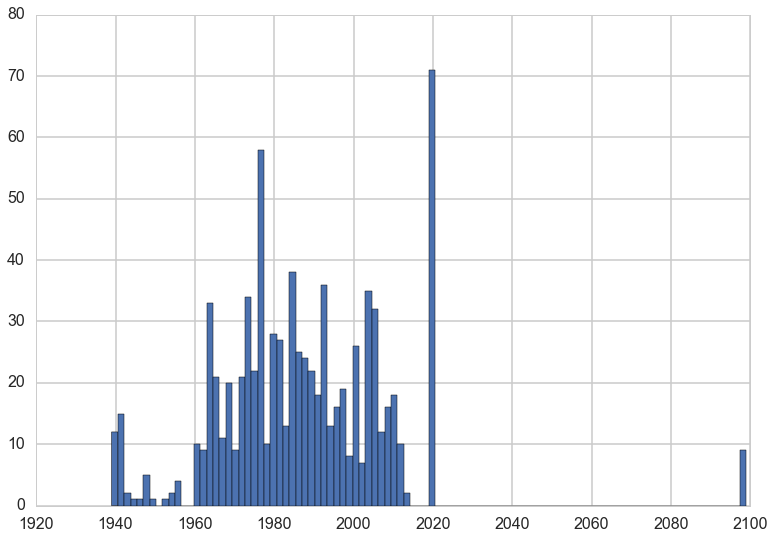

In [10]:
df['Year'].hist(bins=100)

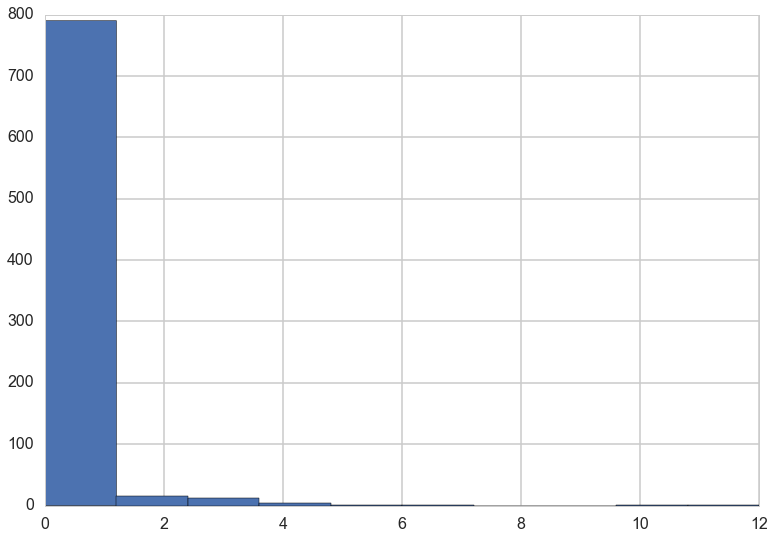

In [11]:
df['PartnershipsCount'].hist()

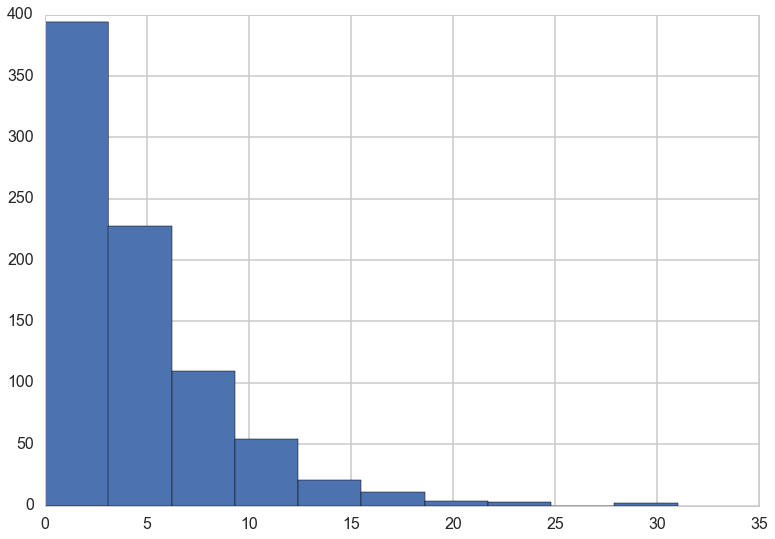

In [12]:
df['AbilitiesCount'].hist()

In [13]:
df[df['AbilitiesCount']==df['AbilitiesCount'].max()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
751,Tarantula,1967,1960,"(Riley),Expert with a whip,(Rodriguez),Great a...",31,NaN,0,https://en.wikipedia.org/wiki/Tarantula_(Marve...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/751.jpg,TARANTULA,NaN,"(RILEY),EXPERT WITH A WHIP,(RODRIGUEZ),GREAT A..."


the not so gifted superheroes

In [14]:
df[df['AbilitiesCount']==1]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
8,Air-Walker,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/8.jpg,AIR-WALKER,NaN,POWER COSMIC
13,Alpha,2012,2010,"Exposure to Parker Particles, able to protract...",1,NaN,0,https://en.wikipedia.org/wiki/Alpha_(Marvel_Co...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/13.jpg,ALPHA,NaN,"EXPOSURE TO PARKER PARTICLES, ABLE TO PROTRACT..."
26,Dirk Anger,2006,2000,Chemically retarded aging process,1,NaN,0,https://en.wikipedia.org/wiki/Dirk_Anger,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/26.jpg,DIRK ANGER,NaN,CHEMICALLY RETARDED AGING PROCESS
31,Apex,2012,2010,Technopath,1,NaN,0,https://en.wikipedia.org/wiki/Apex_(comics),https://None,NaN,APEX,NaN,TECHNOPATH
42,Astra,1977,1970,Density alteration,1,NaN,0,https://en.wikipedia.org/wiki/Astra_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/42.jpg,ASTRA,NaN,DENSITY ALTERATION
45,Atalanta,2020,2020,Energy bow,1,NaN,0,https://en.wikipedia.org/wiki/Atalanta_(Marvel...,https://None,NaN,ATALANTA,NaN,ENERGY BOW
55,Baymax,1998,1990,Morph body into dragon or mecha,1,Hiro Takachiho,1,https://en.wikipedia.org/wiki/Baymax,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/55.jpg,BAYMAX,HIRO TAKACHIHO,MORPH BODY INTO DRAGON OR MECHA
63,Bird-Brain,1987,1980,Flight,1,NaN,0,https://en.wikipedia.org/wiki/Bird-Brain,https://upload.wikimedia.org/wikipedia/en/a/ad...,./img.marvel_chars/63.png,BIRD-BRAIN,NaN,FLIGHT
89,Blink,1994,1990,teleportation,1,Selene,1,https://en.wikipedia.org/wiki/Blink_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/89.jpg,BLINK,SELENE,TELEPORTATION


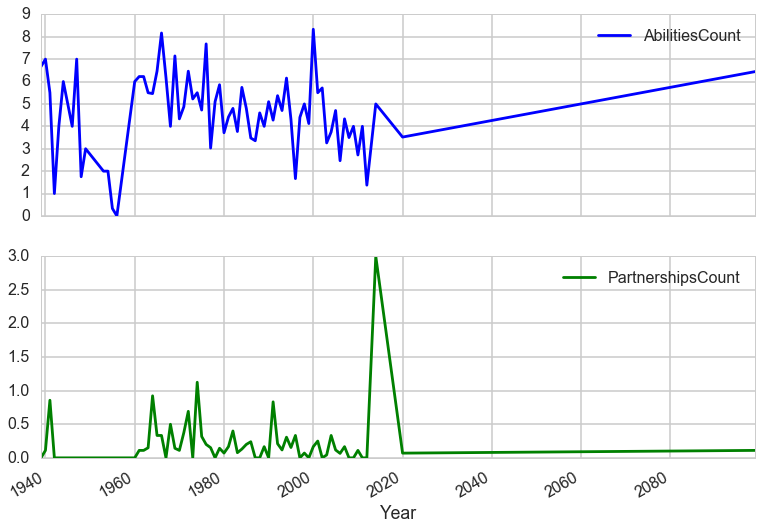

In [15]:
# docs: http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
#fig = plt.figure()
df[['AbilitiesCount','PartnershipsCount','Year']].groupby("Year").mean().plot(subplots=True)
MaxValue = df['Year'].max()
#plt.annotate('My Text', xy=(1000, 5),xytext=(100, 10),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),textcoords='figure points')
plt.show()
#plt.annotate('My Text', xy=(0.5, 0), xycoords='figure fraction',xytext=(0.5, 0.5), textcoords='figure fraction',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

In [16]:
df[(df.Year>=1939) & (df.Year<1945)]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
15,American Ace,1939,1930,NaN,0,NaN,0,https://en.wikipedia.org/wiki/American_Ace,https://None,NaN,AMERICAN ACE,NaN,NaN
23,The Angel,1939,1930,"Excellent acrobat,hand to hand combatant,Accom...",9,NaN,0,https://en.wikipedia.org/wiki/Angel_(Thomas_Ha...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/23.jpg,THE ANGEL,NaN,"EXCELLENT ACROBAT,HAND TO HAND COMBATANT,ACCOM..."
73,Black Marvel,1941,1940,"Excellent hand to hand combatant,Peak physical...",2,NaN,0,https://en.wikipedia.org/wiki/Black_Marvel,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/73.jpg,BLACK MARVEL,NaN,"EXCELLENT HAND TO HAND COMBATANT,PEAK PHYSICAL..."
76,Black Widow,1940,1940,"Superhuman strength,Enhanced endurance,Flight,...",11,NaN,0,https://en.wikipedia.org/wiki/Black_Widow_(Cla...,https://upload.wikimedia.org/wikipedia/en/b/b3...,./img.marvel_chars/76.jpg,BLACK WIDOW,NaN,"SUPERHUMAN STRENGTH,ENHANCED ENDURANCE,FLIGHT,..."
86,Blazing Skull,1941,1940,"Superhuman strength,Immunity to fire,Regenerat...",6,NaN,0,https://en.wikipedia.org/wiki/Blazing_Skull,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/86.jpg,BLAZING SKULL,NaN,"SUPERHUMAN STRENGTH,IMMUNITY TO FIRE,REGENERAT..."
96,Blue Blade,1942,1940,Expert fencer,1,NaN,0,https://en.wikipedia.org/wiki/Blue_Blade,https://upload.wikimedia.org/wikipedia/en/9/96...,./img.marvel_chars/96.jpg,BLUE BLADE,NaN,EXPERT FENCER
97,The Blue Diamond,1941,1940,"Superhuman strength,Nigh-invulnerability,Diamo...",6,NaN,0,https://en.wikipedia.org/wiki/Blue_Diamond_(co...,https://upload.wikimedia.org/wikipedia/en/9/92...,./img.marvel_chars/97.jpg,THE BLUE DIAMOND,NaN,"SUPERHUMAN STRENGTH,NIGH-INVULNERABILITY,DIAMO..."
107,Breeze Barton,1940,1940,"Exceptional hand-to-hand combatant,Enhanced en...",4,NaN,0,https://en.wikipedia.org/wiki/Breeze_Barton,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/107.jpg,BREEZE BARTON,NaN,"EXCEPTIONAL HAND-TO-HAND COMBATANT,ENHANCED EN..."
111,Bucky,1941,1940,"Master hand to hand combatant,martial artist,G...",18,"Captain America,Black Widow",2,https://en.wikipedia.org/wiki/Bucky,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/111.PNG,BUCKY,"CAPTAIN AMERICA,BLACK WIDOW","MASTER HAND TO HAND COMBATANT,MARTIAL ARTIST,G..."
123,Captain America,1941,1940,"Enhanced physical condition,Master martial art...",4,"Bucky (James Barnes),Falcon,Black Widow,Bucky ...",10,https://en.wikipedia.org/wiki/Captain_America,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/123.jpg,CAPTAIN AMERICA,"BUCKY (JAMES BARNES),FALCON,BLACK WIDOW,BUCKY ...","ENHANCED PHYSICAL CONDITION,MASTER MARTIAL ART..."


* Red Tornado ist "great cook"

* https://en.wikipedia.org/wiki/Onslaught_(DC_Comics) checken, interessant wegen Jihad (reiner Zufall, wäre ja jetzt eher Thema)

# create a graph

* hier muss sichergestellt werden, dass edges, die mit min. 2 hero-knoten verbunden sind, gesondert markiert werden

In [17]:

def createAbilityPartnershipGraphs(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()
    G_abilities=nx.Graph()

    # .itertuples() gives us an iterator over all rows in a data frame\n",
    for row in consideredDataFrame.itertuples():
        hero=row[11]
        year=row[2]
        decade=row[3]
        if not hero in G.nodes():
            G.add_node(hero)
            # the name attribute will be helpful for D3.js visualizations
            G.node[hero]['name'] = hero
            G.node[hero]['year'] = year
            G.node[hero]['decade'] = decade
            G.node[hero]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G.node[hero]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G.node[hero]['localFilePath']=localFilePath
            else:
                G.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        if not hero in G_abilities.nodes():
            G_abilities.add_node(hero)
            G_abilities.node[hero]['name'] = hero
            G_abilities.node[hero]['year'] = year
            G_abilities.node[hero]['decade'] = decade
            G_abilities.node[hero]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G_abilities.node[hero]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G_abilities.node[hero]['localFilePath']=localFilePath
            else:
                G_abilities.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        # treat partnerships  (PartnershipsCount)  
        if row[7]: # a shortcut to find out whether a string is empty
            if not row[12]=="NAN":
                partners=row[12].split(",")
                for partner in partners:
                    if not partner in G.nodes():
                        G.add_node(partner)
                        G.node[partner]['name'] = partner
                        G.node[partner]['year'] = year
                        G.node[partner]['decade'] = decade
                        G.node[partner]['group'] = 2
                    G.add_edge(hero,partner)
                    G.edge[hero][partner]['year'] = year
                    G.edge[hero][partner]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G.edges(partner,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G.node[e[0]]['year'] = "XXX"

        # treat abilities
        if row[5]: #AbilitiesCount
            if not row[13]=="NAN":
                abilities=row[13].split(",")
                for ab in abilities:
                    if not ab in G_abilities.nodes():
                        G_abilities.add_node(ab)
                        G_abilities.node[ab]['name'] = ab
                        G_abilities.node[ab]['year'] = year
                        G_abilities.node[ab]['decade'] = decade
                        G_abilities.node[ab]['group'] = 1 # will change the display color in D3.js
                    G_abilities.add_edge(hero,ab)
                    G_abilities.edge[hero][ab]['year'] = year
                    G_abilities.edge[hero][ab]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G_abilities.edges(ab,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G_abilities.node[e[0]]['year'] = "XXX"
                    #print "Adding edge: "+hero+" - "+str(ab)
                #G_abilities.add_edges_from(list(itertools.product(abilities,abilities))) # macht ein cross product der abilities
    return [G,G_abilities]

r=createAbilityPartnershipGraphs(df)

G=r[0]
G_abilities=r[1]

In [18]:
print G.number_of_nodes()
print G.number_of_edges()

886
154


In [19]:
print G_abilities.number_of_nodes()
print G_abilities.number_of_edges()

3038
3976


klassischerweise schaut man sich nun einige eigenschaften des graphs an (orientiert an https://en.wikipedia.org/wiki/Social_network_analysis):

In [22]:
import networkx.algorithms.approximation.clique as cliq
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set
from networkx.algorithms.approximation.independent_set import maximum_independent_set

print "assortativity: %f" % nx.degree_assortativity_coefficient(G_abilities)

#
#
centralityDegrees=[]
eigenvectorCentralities=[]

centrality=nx.degree_centrality(G_abilities)
#eigenvectorC=nx.eigenvector_centrality(G_abilities)

# https://en.wikipedia.org/wiki/Dominating_set
mwdSet=min_weighted_dominating_set(G_abilities)
dominatingHeroes=[]

for row in df.itertuples():
        hero=row[11]
        if hero in centrality:
            #print "\t"+hero+": "+str(centrality[hero])
            centralityDegrees.append(centrality[hero])
        #if hero in eigenvectorC:
            #eigenvectorCentralities.append(eigenvectorC[hero])
        if hero in mwdSet:
            dominatingHeroes.append(hero)
# errors='ignore' is added for the case that the 'CentralityDegree' column does not exist, e.g., at the first run of this cell
df.drop("CentralityDegree",inplace=True,axis=1,errors='ignore')
df.insert(loc=13,column="CentralityDegree",value=centralityDegrees)
#df.insert(loc=14,column="EigenvectorCentrality",value=eigenvectorCentralities)

# https://en.wikipedia.org/wiki/Clustering_coefficient
print "Average clustering coefficient: "+str(nx.average_clustering(G_abilities))

print "\n\nMIN WEIGHTED DOMINATING SET (number of nodes: %i vs. total nodes: %i)\n\n%s"%(len(mwdSet),G_abilities.number_of_nodes(),str(dominatingHeroes))
# crashes?
#print "\n\nMAX INDEPENDENT SET\n\n"+str(maximum_independent_set(G_abilities))
#extremely slow (NP!!!)
#print cliq.max_clique(G_abilities)
#slow
#print "betweenness_centrality: %s" % str(nwacb.betweenness_centrality(G_abilities))

assortativity: -0.048063
Average clustering coefficient: 4.13381872361e-05


MIN WEIGHTED DOMINATING SET (number of nodes: 2996 vs. total nodes: 3038)

[u'ABIGAIL BRAND', u'ABYSS', u'ACCESS', u'ADEPT', u'AEGIS', u'AGENT X', u'EL \xc1GUILA', u'AHURA', u'AIR-WALKER', u'AJAK', u'AJAX', u'AKASHA', u'ALBERT', u'ALPHA', u'ALPHA THE ULTIMATE MUTANT', u'AMERICAN ACE', u'AMERICAN DREAM', u'AMERICAN EAGLE', u'AMERICOP', u'AMINEDI', u'MARVEL COMICS ALTERNATE UNIVERSES', u'ANACHRONISM', u'ANDROMEDA', u'THE ANGEL', u'ANGEL DUST', u'ANGELA', u'DIRK ANGER', u'ANNEX', u'ANOLE', u'ANT-MAN', u'ANTHEM', u'APEX', u'ARABIAN KNIGHT', u'ARAGORN', u'ANYA CORAZON', u'ARCANNA', u'ARCHER', u'ARES', u'ARIEL', u'ARKON', u'ARMOR', u'ARMORY', u'ASTRA', u'VANCE ASTRO', u'VANCE ASTROVIK', u'ATALANTA', u'ATHENA', u'AURORA', u'BACKHAND', u'BALDER THE BRAVE', u'BANSHEE', u'RIKKI BARNES', u'BASE', u'BATTLESTAR', u'BATWING', u'BAYMAX', u'BEAST', u'BEDLAM', u'BEETLE', u'BENGAL', u'BEREET', u'BETA RAY BILL', u'BIG BERTHA', u

In [23]:
df.sort_values(by="CentralityDegree").tail()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps,CentralityDegree
373,John Jameson,1963,1960,"Skilled pilot,astronaut,Experienced hand-to-ha...",23,NaN,0,https://en.wikipedia.org/wiki/John_Jameson_(co...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/373.png,JOHN JAMESON,NaN,"SKILLED PILOT,ASTRONAUT,EXPERIENCED HAND-TO-HA...",0.007573
508,Nighthawk,1969,1960,"Kyle (Earth-616):,Superb athlete,Mild superhum...",24,NaN,0,https://en.wikipedia.org/wiki/Nighthawk_(Marve...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/508.jpg,NIGHTHAWK,NaN,"KYLE (EARTH-616):,SUPERB ATHLETE,MILD SUPERHUM...",0.007573
751,Tarantula,1967,1960,"(Riley),Expert with a whip,(Rodriguez),Great a...",31,NaN,0,https://en.wikipedia.org/wiki/Tarantula_(Marve...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/751.jpg,TARANTULA,NaN,"(RILEY),EXPERT WITH A WHIP,(RODRIGUEZ),GREAT A...",0.008232
397,Kaine Parker,1994,1990,"(As Kaine) :,Superhuman strength,speed,agility...",29,NaN,0,https://en.wikipedia.org/wiki/Kaine,https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/397.jpg,KAINE PARKER,NaN,"(AS KAINE) :,SUPERHUMAN STRENGTH,SPEED,AGILITY...",0.008232
696,Speed,2006,2000,"Superhuman speed,Molecular acceleration,Superh...",4,NaN,0,https://en.wikipedia.org/wiki/Speed_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.marvel_chars/696.png,SPEED,NaN,"SUPERHUMAN SPEED,MOLECULAR ACCELERATION,SUPERH...",0.026013


In [24]:
#from networkx.algorithms.shortest_paths.generic import all_shortest_paths
#f=all_shortest_paths(G,"BATMAN","THE JOKER")

#print([p for p in f])

In [25]:
from networkx.algorithms.assortativity.neighbor_degree import average_neighbor_degree
average_neighbor_degree(G_abilities)

{u'': 12.0,
 u'DARKHAWK': 51.42857142857143,
 u'PHYLA-VELL': 65.2,
 u'LATER': 7.0,
 u'EXTERNAL CONTROLS ON ITS THORAX': 12.0,
 u'DIMENSIONAL TRAVEL': 12.0,
 u'SILENCER': 14.5,
 u'ABILITY TO COMMUNICATE WITH THE  DREAMING CELESTIAL': 17.0,
 u'ABILITY TO BECOME NEARLY TWO-DIMENSIONAL': 9.0,
 u"BEAST 'S ANIMALISTIC PHYSICAL TRAITS": 9.0,
 u'ELECTROMAGNETIC MANIPULATION': 5.5,
 u'REFLEXES (COMMON AMONG THE INHUMANS)': 8.0,
 u'SPY': 13.0,
 u'VAMPIRE BY NIGHT': 25.545454545454547,
 u'MERGE WITH IT': 5.0,
 u'ABILITY TO CREATE ADVANCED DEVICES': 12.0,
 u'ENGINEERING': 10.0,
 u'BREAK DOWN': 4.0,
 u'MODRED THE MYSTIC': 0.0,
 u'ABILITY TO TRANSFORM INTO WOLF-LIKE CREATURE:': 4.0,
 u'EXPERT PRACTITIONER OF THE CHINESE MARTIAL ARTS': 2.0,
 u'ABILITY TO TRAVEL BETWEEN INTERDIMENSIONAL REALMS': 11.0,
 u'A BLADE CALLED THE "PSCYTHE" THAT CAN CUT THROUGH ANY MATERIAL': 1.0,
 u'STAR BRAND': 0.0,
 u'SKILLED COMBATANT': 2.5,
 u'SONIC SCREAMS': 10.0,
 u'ENHANCED STRENGTH': 6.285714285714286,
 u'MASS OF HER

# Weitere Ideen

* mit Google nGrams abgleichen? https://books.google.com/ngrams/graph?content=Skilled%2C+magic&case_insensitive=on&year_start=1963&year_end=1965&corpus=16&smoothing=3&share=&direct_url=t4%3B%2CSkilled%3B%2Cc0%3B%2Cs0%3B%3Bskilled%3B%2Cc0%3B%3BSkilled%3B%2Cc0%3B.t4%3B%2Cmagic%3B%2Cc0%3B%2Cs0%3B%3Bmagic%3B%2Cc0%3B%3BMagic%3B%2Cc0%3B%3BMAGIC%3B%2Cc0

* x

## Using the Data in Your Website

In [26]:
import json
from networkx.readwrite import json_graph

#d = json_graph.node_link_data(G)
d = json_graph.node_link_data(G_abilities)
jsonPath='./force/'+pathPrefix+'/force.json'
json.dump(d, open(jsonPath,'w'))

printLog("Saved JSON file to: "+jsonPath)
# weitere notwendige Files für D3.js visualization unter: /Users/david/Documents/src/javascript/visualization
# examples taken from https://github.com/networkx/networkx/tree/master/examples/javascript

[2016-02-16 20:11:53.951482]	Saved JSON file to: ./force/marvel/force.json


# Analyses per Decade

In [27]:
decades=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
dataframes=OrderedDict()
for decade in decades:
    dfTemp=df[(df.Decade==decade)]
    dataframes[decade]=dfTemp

In [28]:
df[df.Decade==2020].describe()

,Year,Decade,AbilitiesCount,PartnershipsCount,CentralityDegree
count,71,71,71.000000,71.000000,71.000000
mean,2020,2020,3.521127,0.070423,0.001159
std,0,0,3.446983,0.425070,0.001135
min,2020,2020,0.000000,0.000000,0.000000
25%,2020,2020,1.000000,0.000000,0.000329
50%,2020,2020,2.000000,0.000000,0.000659
75%,2020,2020,5.000000,0.000000,0.001646
max,2020,2020,18.000000,3.000000,0.005927


In [29]:
groupedStats=df[['AbilitiesCount','PartnershipsCount',"Decade"]].groupby("Decade").count()
groupedStats.to_csv("./force/"+pathPrefix+"/decadeStats.csv")

In [30]:
for decade in dataframes:
    currentDF=dataframes[decade]
    r=createAbilityPartnershipGraphs(currentDF)
    d = json_graph.node_link_data(r[1])
    jsonPath='./force/'+pathPrefix+"/"+str(decade)+'.json'
    json.dump(d, open(jsonPath,'w'))

    printLog("Saved JSON file to: "+jsonPath)

[2016-02-16 20:11:54.028961]	Saved JSON file to: ./force/marvel/1900.json
[2016-02-16 20:11:54.034027]	Saved JSON file to: ./force/marvel/1910.json
[2016-02-16 20:11:54.038542]	Saved JSON file to: ./force/marvel/1920.json
[2016-02-16 20:11:54.043969]	Saved JSON file to: ./force/marvel/1930.json
[2016-02-16 20:11:54.059720]	Saved JSON file to: ./force/marvel/1940.json
[2016-02-16 20:11:54.064399]	Saved JSON file to: ./force/marvel/1950.json
[2016-02-16 20:11:54.127039]	Saved JSON file to: ./force/marvel/1960.json
[2016-02-16 20:11:54.210291]	Saved JSON file to: ./force/marvel/1970.json
[2016-02-16 20:11:54.611058]	Saved JSON file to: ./force/marvel/1980.json
[2016-02-16 20:11:54.688969]	Saved JSON file to: ./force/marvel/1990.json
[2016-02-16 20:11:54.754086]	Saved JSON file to: ./force/marvel/2000.json
[2016-02-16 20:11:54.766787]	Saved JSON file to: ./force/marvel/2010.json
[2016-02-16 20:11:54.794934]	Saved JSON file to: ./force/marvel/2020.json


# Erklärungsversuche

* The first Green Lantern character, Alan Scott, was created in 1940 during the initial popularity of superheroes. Alan Scott usually fought common criminals in New York City with the aid of his magic ring. The publication of this character ceased in 1949 during a general decline in the popularity of superhero comics, but the character saw a limited revival in later decades.

* After World War II the popularity of superheroes in general declined. The Green Lantern comic book was cancelled with issue #38 (May–June 1949), and All Star Comics #57 (1951) was the character's last Golden Age appearance. When superheroes came back in fashion in later decades, Alan Scott was revived, but was forever marginalized by the new Hal Jordan character who had been created to supplant him (see below

In [32]:
import http_server
http_server.load_url('force/force.html')

Webserver working directory: /Users/david/Documents/src/python/CulturalAnalytics


127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/force.html HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/force.css HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/barchart.js HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/marvel/force.json HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:08] "GET /force/marvel/decadeStats.csv HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/img.marvel_chars/177.jpg HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/img.marvel_chars/548.png HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/img.marvel_chars/482.jpg HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/img.marvel_chars/717.jpg HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/blank.png HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2016 11:10:10] "GET /force/img.marvel_chars/602.jpg HTTP/1.1" 200 -
12

KeyboardInterrupt: 

* niemals "interrupt kernel" zum beenden wählen, sonst muss man das gesamte notebook shutdown machen, da der webserver sonst nicht mehr den port 8000 freigibt, zum stop immer "enter" drücken
* http_server.pyc muss gelöscht werden, wenn man etwas an http_server.py ändert